In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !git clone https://github.com/plutasnyy/uwmadison.git

In [3]:
# import sys
# sys.path.append('/kaggle/working/uwmadison')

In [4]:
import os
from src.data_processing.constants import (
    KAGGLE_DATA_PATH,
    KAGGLE_OUTPUT_DATA_PATH,
    LOCAL_DATA_PATH,
    LOCAL_OUTPUT_DATA_PATH,
)

IS_KAGGLE = os.environ.get("KAGGLE_KERNEL_RUN_TYPE", "") != ""
DATA_DIR = KAGGLE_DATA_PATH if IS_KAGGLE else LOCAL_DATA_PATH
OUTPUT_DIR = KAGGLE_OUTPUT_DATA_PATH if IS_KAGGLE else LOCAL_OUTPUT_DATA_PATH

In [5]:
from src.data_processing.data_utils import prepare_df
from tqdm import tqdm

tqdm.pandas()

new_df = prepare_df(data_directory=DATA_DIR)
new_df.head()

100%|██████████| 38496/38496 [01:18<00:00, 492.38it/s]


,id,class,segmentation,case,day,slice,image_path,height,width
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1,/home/plutasnyy/git/uwmadison/uw-madison-gi-tr...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,1,/home/plutasnyy/git/uwmadison/uw-madison-gi-tr...,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,1,/home/plutasnyy/git/uwmadison/uw-madison-gi-tr...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,2,/home/plutasnyy/git/uwmadison/uw-madison-gi-tr...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,2,/home/plutasnyy/git/uwmadison/uw-madison-gi-tr...,266,266


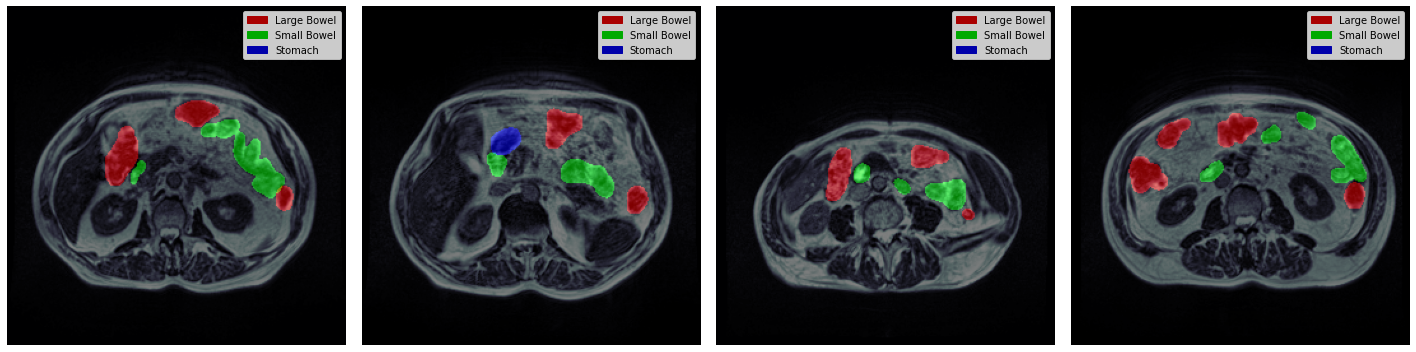

In [7]:
from src.image_utils import load_img, show_img
from src.data_processing.data_utils import id2mask
from matplotlib import pyplot as plt

row = 1
col = 4
plt.figure(figsize=(5 * col, 5 * row))
random_slices_to_plot = (
    new_df[~new_df.segmentation.isna()].sample(frac=1.0)["id"].unique()[: row * col]
)
for i, id_ in enumerate(random_slices_to_plot):
    img = load_img(new_df[new_df["id"] == id_].image_path.iloc[0])
    mask = id2mask(id_, df=new_df) * 255
    plt.subplot(row, col, i + 1)
    show_img(img, mask=mask)
    plt.tight_layout()

In [8]:
from src.data_processing.data_utils import save_mask

save_mask(id_="case123_day22_slice_0117", df=new_df, save_dir=OUTPUT_DIR)

/home/plutasnyy/git/uwmadison/uw-madison-gi-tract-image-segmentation/data_processed/np/case123_day22_slice_0117.npy


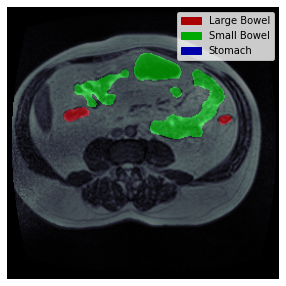

In [9]:
import numpy as np

img = load_img(new_df[new_df["id"] == "case123_day22_slice_0117"].iloc[0].image_path)
mask_path = OUTPUT_DIR / "np" / "case123_day22_slice_0117.npy"
print(mask_path)
mask = np.load(str(mask_path))
plt.figure(figsize=(5, 5))
show_img(img, mask)

In [10]:
ids = new_df["id"].unique()
save_mask(ids[5], new_df)

In [11]:
from tqdm import tqdm
from joblib import delayed, Parallel

ids = new_df["id"].unique()
_ = Parallel(n_jobs=-1, backend="threading")(
    delayed(save_mask)(id_, new_df, OUTPUT_DIR) for id_ in tqdm(ids, total=len(ids))
)

100%|██████████| 38496/38496 [10:26<00:00, 61.47it/s]


In [12]:
new_df["mask_path_png"] = str(OUTPUT_DIR) + "/png/" + new_df.id + ".png"
new_df["mask_path_np"] = str(OUTPUT_DIR) + "/np/" + new_df.id + ".npy"

In [13]:
new_df.head()

,id,class,segmentation,case,day,slice,image_path,height,width,mask_path_png,mask_path_np
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1,/home/plutasnyy/git/uwmadison/uw-madison-gi-tr...,266,266,/home/plutasnyy/git/uwmadison/uw-madison-gi-tr...,/home/plutasnyy/git/uwmadison/uw-madison-gi-tr...
1,case123_day20_slice_0001,small_bowel,NaN,123,20,1,/home/plutasnyy/git/uwmadison/uw-madison-gi-tr...,266,266,/home/plutasnyy/git/uwmadison/uw-madison-gi-tr...,/home/plutasnyy/git/uwmadison/uw-madison-gi-tr...
2,case123_day20_slice_0001,stomach,NaN,123,20,1,/home/plutasnyy/git/uwmadison/uw-madison-gi-tr...,266,266,/home/plutasnyy/git/uwmadison/uw-madison-gi-tr...,/home/plutasnyy/git/uwmadison/uw-madison-gi-tr...
3,case123_day20_slice_0002,large_bowel,NaN,123,20,2,/home/plutasnyy/git/uwmadison/uw-madison-gi-tr...,266,266,/home/plutasnyy/git/uwmadison/uw-madison-gi-tr...,/home/plutasnyy/git/uwmadison/uw-madison-gi-tr...
4,case123_day20_slice_0002,small_bowel,NaN,123,20,2,/home/plutasnyy/git/uwmadison/uw-madison-gi-tr...,266,266,/home/plutasnyy/git/uwmadison/uw-madison-gi-tr...,/home/plutasnyy/git/uwmadison/uw-madison-gi-tr...


In [14]:
new_df.to_csv("new_train.csv", index=False)

In [15]:
import shutil

if IS_KAGGLE:
    shutil.make_archive("/kaggle/working/png", "zip", str(OUTPUT_DIR / "png"))

In [16]:
if IS_KAGGLE:
    shutil.make_archive("/kaggle/working/np", "zip", str(OUTPUT_DIR / "np"))